# From simulator to Inference with HDDM (MNLE Version)

In this tutorial we show how to proceed from a *simulator model* to Bayesian Inference with HDDM, via training a *likelihood approximator* of the [MNLE](https://elifesciences.org/articles/77220) type. 

MNLE stands for Mixed Neural Likelihood Estimator,
which in turn is a Neural Network composed of the combination of a [Flow](https://en.wikipedia.org/wiki/Flow-based_generative_model), and a basic classifier [MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron). 
MNLEs are designed for predicting (and generating data from) likelihoods over *mixed* data containing a continuous and a discrete part.

In the context of *Sequential Sampling Models*, the continuous part refers to the *reaction times*, while the discrete part refers to *choices*.

We will make use of two python packages which help facilitate this tutorial:

1. The [`ssms`](https://github.com/AlexanderFengler/ssm_simulators) package, which holds a collection of fast simulators and training data generators for LANs (here we make use only of the basic simulators and ignore the LAN integration)
2. The [`sbi`](https://github.com/AlexanderFengler/LANfactory) package, which makes training MNLEs easy. The package has a much broader scope, which we suggest the interested user to explore, however not all aspects of the `sbi` toolbox allow for an interface with HDDM.

In this tutorial we will start by simulating data from the DDM, using the [`ssms`](https://github.com/AlexanderFengler/ssm_simulators), then use this data to train a MNLE via the [`sbi`](https://github.com/AlexanderFengler/LANfactory) toolbox and finally define a wrapper around the resulting MNLE to make it usable in HDDM.


## Installation (colab)

**NOTE:**
If you run this Tutorial in a **google colab**, don't forget to change the **runtime** to a **GPU** machine for better performance.

In [3]:
# !pip install sbi
# !pip install cython
# !pip install pymc==2.3.8
# !pip install git+https://github.com/hddm-devs/kabuki
# !pip install git+https://github.com/hddm-devs/hddm
# !pip install git+https://github.com/AlexanderFengler/ssm_simulators

## Load Modules

In [32]:
# ssms for simulation
from ssms.basic_simulators import simulator

# sbi for network training
import sbi
from sbi.inference import MNLE

# HDDM
import hddm

# Misc
from copy import deepcopy
import ssms
import torch
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

## Simulate Data

In [20]:
from ssms.config import model_config

# Define our model
model = "ddm"

# Load corresponding config dictionary
model_config_tmp = deepcopy(model_config["ddm"])
model_config_tmp["choices"] = [
    -1,
    1,
]  # simple addition to make ssms model config hddm ready

# Choose number of training examples
n_training_examples = 100000

# Generate a matrix of model parameters
# We sample this uniformly from an allowed parameter space
thetas = np.random.uniform(
    low=model_config_tmp["param_bounds"][0],
    high=model_config_tmp["param_bounds"][1],
    size=(n_training_examples, len(model_config_tmp["params"])),
)
thetas_torch = torch.Tensor(thetas)

# For every row in thetas, draw 1 sample from the DDM.
model_simulations = ssms.basic_simulators.simulator.simulator(
    model="ddm", theta=thetas, n_samples=1
)

# Format the output of the simulator
model_simulations_torch = torch.Tensor(
    np.hstack((model_simulations["rts"], model_simulations["choices"]))
)

# Edit choices to [0,1] (the simulator produces [-1, 1]) since that is the format MNLE expects.
model_simulations_torch[:, 1] = (model_simulations_torch[:, 1] + 1) / 2

## Train Network

In [27]:
# Set device
torch_device = (
    torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)

# Initialise Prior
prior = sbi.utils.BoxUniform(
    low=torch.tensor(ssms.config.model_config["ddm"]["param_bounds"][0]),
    high=torch.tensor(ssms.config.model_config["ddm"]["param_bounds"][1]),
    device=torch_device.type,
)

# Initialise the MNLE trainer
trainer = MNLE(prior=prior, device=torch_device.type)

# Add presimulated training data to the MNLE trainer
trainer = trainer.append_simulations(thetas_torch, model_simulations_torch)

# Train the network and return the resulting MNLE
mnle = trainer.train(training_batch_size=128 if torch_device.type == "cpu" else 1000)

/Users/afengler/opt/miniconda3/envs/hddmnn_tutorial/lib/python3.7/site-packages/sbi/neural_nets/mnle.py:64: UserWarning: The mixed neural likelihood estimator assumes that x contains
        continuous data in the first n-1 columns (e.g., reaction times) and
        categorical data in the last column (e.g., corresponding choices). If
        this is not the case for the passed `x` do not use this function.
  this is not the case for the passed `x` do not use this function."""


 Neural network successfully converged after 74 epochs.

## Run in HDDM

### Define HDDM Network

In [28]:
class MNLEWrapper:
    def __init__(self, MNLE):
        self.mnle = MNLE
        self.dev = (
            torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        )

    # We need to define a predict on batch method for compatibility with HDDM
    def predict_on_batch(self, data):
        # HDDM supplies decisions as [-1, 1], which we adjust
        # to [0, 1] for the MNLE
        data[:, -1] = (data[:, -1] + 1) / 2

        return (
            self.mnle.log_prob(
                torch.tensor(data[:, -2:]).to(self.dev),  # supply (rt, choice)
                torch.tensor(data[:, :-2]).to(self.dev),  # supply (theta)
            )
            .cpu()
            .detach()
            .numpy()
        )  # send back to cpu (for MCMC sampler to proceed)

The argument `x`, to the `predict_on_batch()`, when called from within HDDM's sampler, will be a matrix. 
Rows correspond to trials, and columns are supplied in the following way. 

The first few columns contain trial wise parameters (in the order specific in the `model_config` above under the `"params"` `key`).
The last two columns contain the trial wise *reaction times* and *choices* respectively.

To understand how the network is actually called in HDDM, let's take a peak into the *generic internal likelihood function*.

**NOTE:**
Don't actually run the cell below. It is just for illustration.

In [51]:
def wiener_like_nn_mlp_pdf(np.ndarray[float, ndim = 1] rt,
                           np.ndarray[float, ndim = 1] response,
                           np.ndarray[float, ndim = 1] params,
                           double p_outlier = 0, 
                           double w_outlier = 0,
                           bint logp = 0,
                           network = None):
    
    cdef Py_ssize_t size = rt.shape[0]
    cdef Py_ssize_t n_params = params.shape[0]

    cdef np.ndarray[float, ndim = 1] log_p = np.zeros(size, dtype = np.float32)
    cdef float ll_min = -16.11809

    cdef np.ndarray[float, ndim = 2] data = np.zeros((size, n_params + 2), dtype = np.float32)
    data[:, :n_params] = np.tile(params, (size, 1)).astype(np.float32)
    data[:, n_params:] = np.stack([rt, response], axis = 1)

    # Call to network:
    if p_outlier == 0: 
        log_p = np.squeeze(np.core.umath.maximum(network.predict_on_batch(data), ll_min))
    else: # ddm_model
        log_p = np.squeeze(np.log(np.exp(np.core.umath.maximum(network.predict_on_batch(data), ll_min)) * (1.0 - p_outlier) + (w_outlier * p_outlier)))
    if logp == 0:
        log_p = np.exp(log_p) 
    return log_p

We see that the *internal likelihood function* expects a network as input and then finally calls the `predict_on_batch()` to get log-likelihoods. 

We can now initialize the HDDM-ready MNLE via our `MNLEWrapper()` class, after which we are essentially good to go for an HDDM application.

In [29]:
# Initalize HDDM ready MNLE
mnle_hddm = MNLEWrapper(MNLE=mnle)

### Generate Example Data

In [30]:
# Choose some parameters
v = 0.9
a = 1.4
z = 0.45
t = 0.7

# Simulate Data
data = ssms.basic_simulators.simulator(model=model, theta=[v, a, z, t], n_samples=500)

# Bring into correct shape expected from HDDM
data_df = pd.DataFrame(
    np.stack([data["rts"], data["choices"]], axis=1)[:, :, 0],
    columns=["rt", "response"],
)
data_df["subj_idx"] = 0
data_df["v"] = v
data_df["a"] = a
data_df["z"] = z
data_df["t"] = t

data_df

,rt,response,subj_idx,v,a,z,t
0,1.106998,1.0,0,0.9,1.4,0.45,0.7
1,1.396995,1.0,0,0.9,1.4,0.45,0.7
2,2.062008,1.0,0,0.9,1.4,0.45,0.7
3,5.708819,1.0,0,0.9,1.4,0.45,0.7
4,1.877999,1.0,0,0.9,1.4,0.45,0.7
...,...,...,...,...,...,...,...
495,3.119007,1.0,0,0.9,1.4,0.45,0.7
496,1.972003,1.0,0,0.9,1.4,0.45,0.7
497,1.719992,1.0,0,0.9,1.4,0.45,0.7
498,1.735992,1.0,0,0.9,1.4,0.45,0.7


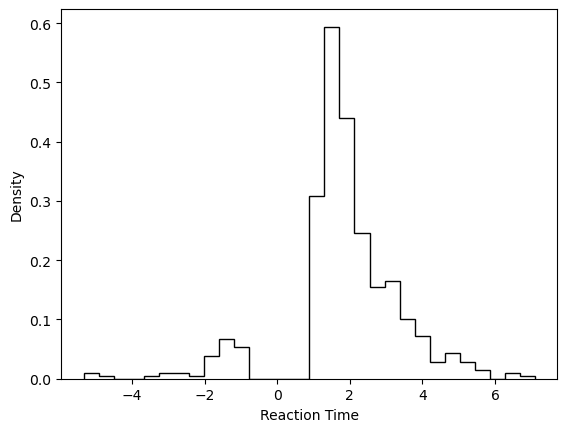

In [49]:
# Plotting the RTs
plt.hist(
    data_df["rt"] * data_df["response"],
    histtype="step",
    color="black",
    density=True,
    bins=30,
)
plt.xlabel("Reaction Time")
plt.ylabel("Density")
plt.show()

### Define HDDM Model

In [38]:
# Define the HDDM model
hddmmnle_model = hddm.HDDMnn(
    data=data_df,
    informative=False,
    include=model_config_tmp[
        "hddm_include"
    ],  # Note: This include statement is an example, you may pick any other subset of the parameters of your model here
    model=model,
    model_config=model_config_tmp,
    network=mnle_hddm,
)

Supplied model_config does not have a params_std_upper argument.
Set to a default of 10
Supplied model_config does not have a params_std_upper argument.
Set to a default of 10
Supplied model_config does not have a params_std_upper argument.
Set to a default of 10
Supplied model_config does not have a params_std_upper argument.
Set to a default of 10


### Sample

In [39]:
# Sample from the model
n_mcmc = 1000
n_burn = 100

hddmmnle_model.sample(n_mcmc, burn=n_burn)

 [-----------------100%-----------------] 1001 of 1000 complete in 360.0 sec

In [40]:
# Show posterior summary
tmp = hddmmnle_model.gen_stats()
tmp["ground_truth"] = data_df.iloc[0, 3:]
tmp[["ground_truth", "mean", "std"]]

,ground_truth,mean,std
v,0.90,1.024209,0.071095
a,1.40,1.461075,0.054512
z,0.45,0.413947,0.02392
t,0.70,0.695977,0.037936


### Plots

We show two plots. *First*, we compare simulations fixing the parameters at the posterior mean with the original data, to get a visual idea of the model fit we obtained. *Second* we show the posterior traces.

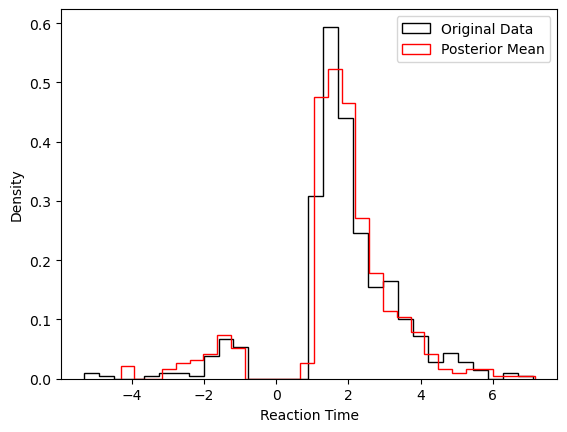

In [48]:
# Compare simulations from posterior mean parameters
# to original data
data_post_mean = data = ssms.basic_simulators.simulator(
    model=model, theta=list(tmp["mean"].values), n_samples=500
)


# Plotting the RTs
plt.hist(
    data_df["rt"] * data_df["response"],
    histtype="step",
    color="black",
    density=True,
    bins=30,
    label="Original Data",
)
plt.hist(
    data_post_mean["rts"] * data_post_mean["choices"],
    histtype="step",
    color="red",
    density=True,
    bins=30,
    label="Posterior Mean",
)
plt.xlabel("Reaction Time")
plt.ylabel("Density")
plt.legend()
plt.show()

Plotting v
Plotting a
Plotting z
Plotting t


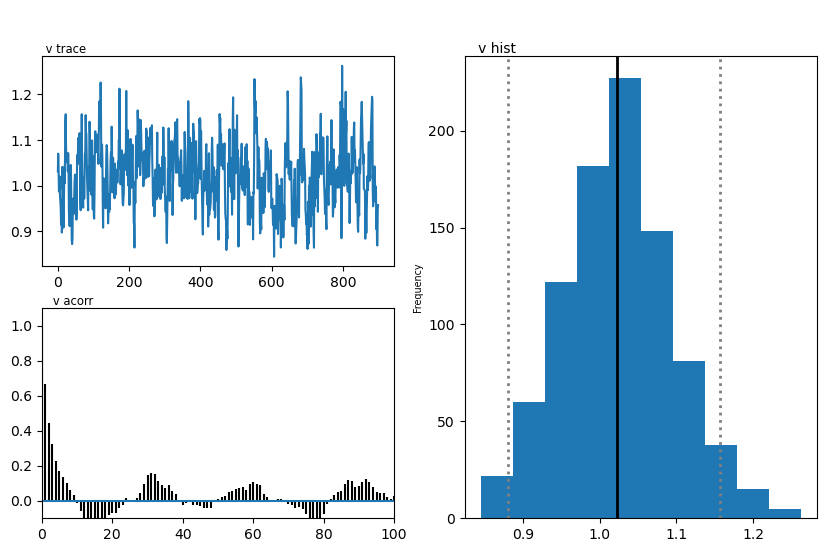

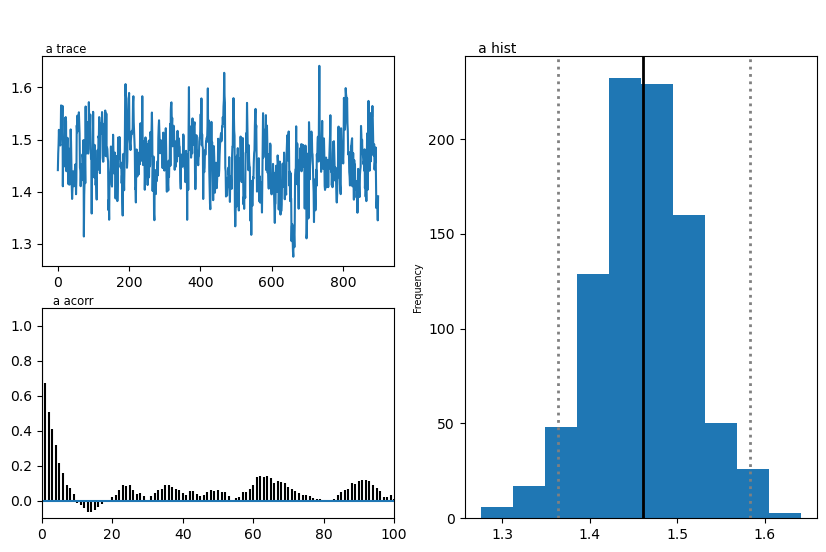

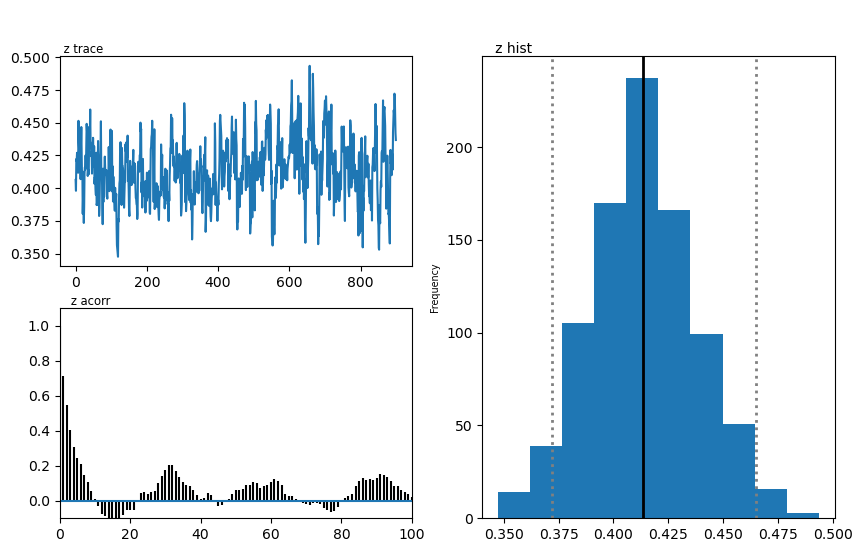

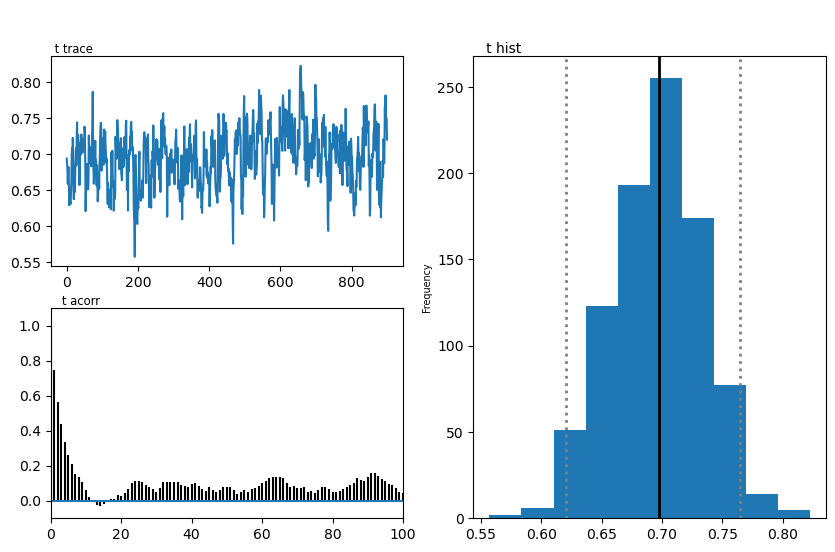

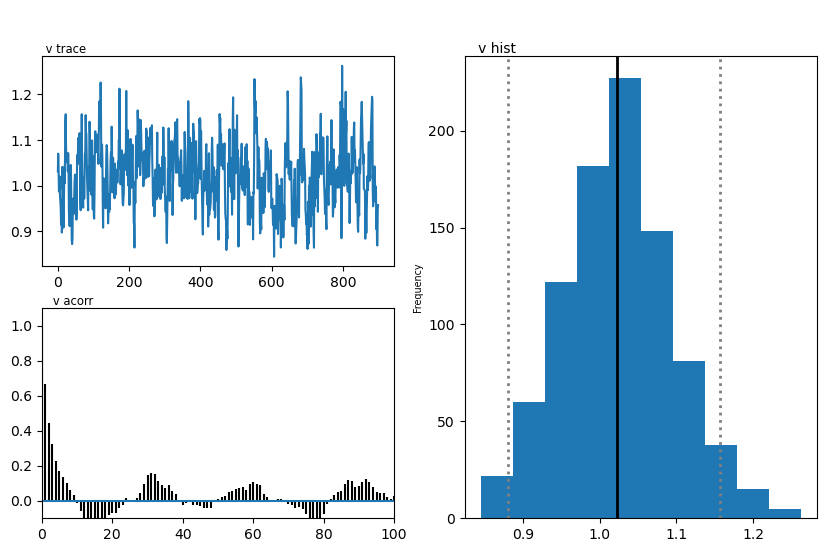

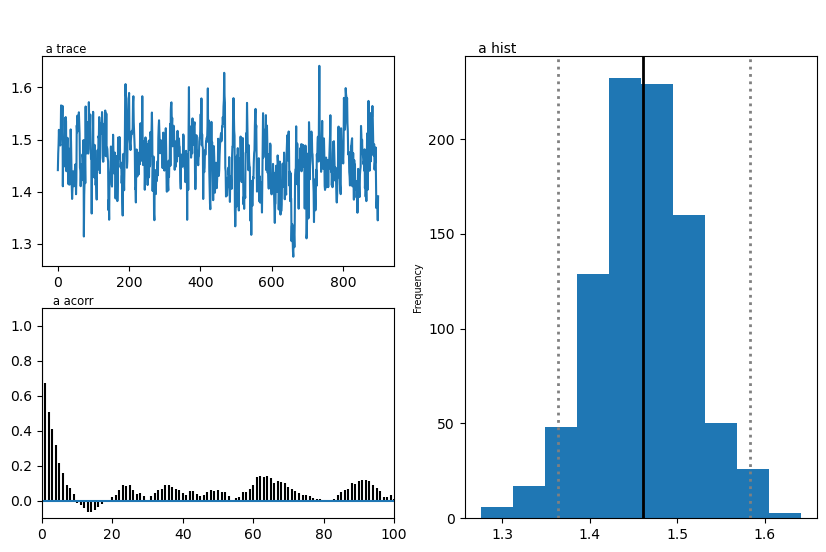

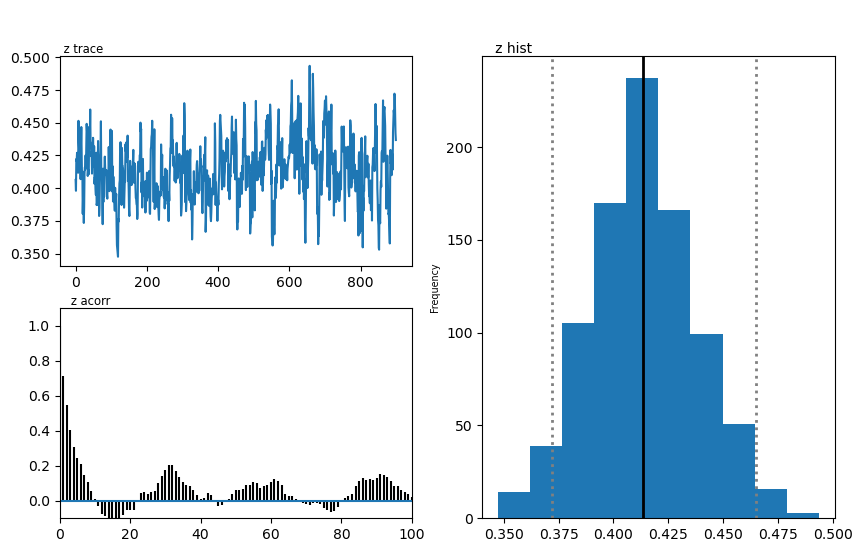

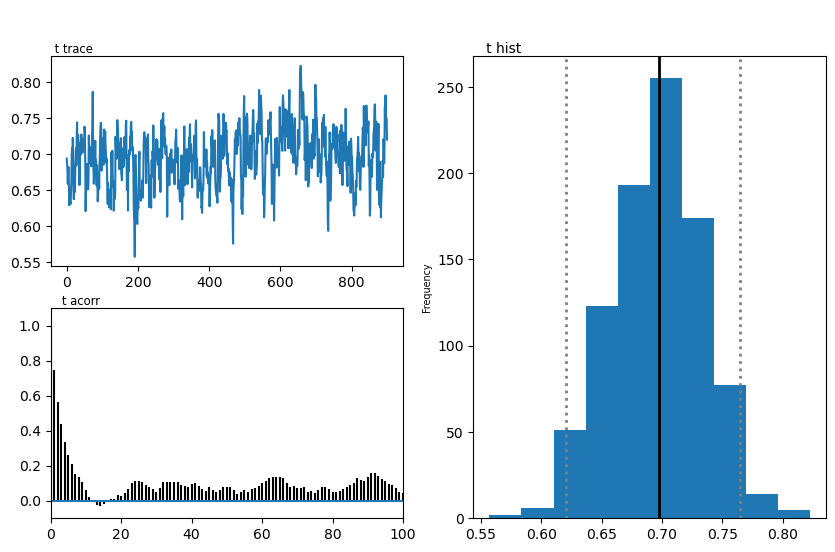

In [42]:
# Plot the posteriors
hddmmnle_model.plot_posteriors()
plt.show()